In [1]:
import os
batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
import jax
num_cores = jax.local_device_count()
import inference_gym.using_jax as gym


import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns

from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error

from blackjax.diagnostics import effective_sample_size
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian

from sampler_evaluation.models.banana_mams_paper import banana_mams_paper
import sampler_evaluation 
import itertools


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
 

In [2]:

def ess(model, sampler, contract_fn, batch_size=128):

    # batch_size = 128
    init_keys = jax.random.split(jax.random.key(3), batch_size)
    keys = jax.random.split(jax.random.key(3), batch_size)
    initial_position = jax.vmap(lambda key: initialize_model(model, key))(init_keys)
    num_steps = 20000

    samples, metadata = jax.pmap(
            lambda key, pos: samplers[sampler](return_samples=True)(
            model=model, num_steps=num_steps, initial_position=pos, key=key
            )
            )(
            keys,
            initial_position,
            )
    
    error_at_each_step = get_standardized_squared_error(
        samples, 
        f=lambda x:x**2,
        E_f=model.sample_transformations["square"].ground_truth_mean,
        Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
        contract_fn=contract_fn[1]
        )

    gradient_calls_per_proposal = metadata['num_grads_per_proposal'].mean()
    samples_to_low_err = samples_to_low_error(error_at_each_step) * gradient_calls_per_proposal
    ess_correlation = contract_fn[0](effective_sample_size(samples) / (num_steps * batch_size * gradient_calls_per_proposal))
    ess_bias = 100 / samples_to_low_err
    return ess_correlation, ess_bias, samples_to_low_err

In [3]:


model = banana_mams_paper

models = [
    sampler_evaluation.models.german_credit(),
    banana_mams_paper, 
    sampler_evaluation.models.brownian_motion(),
    ]

for model, sampler in itertools.product(models, ['nuts', 'adjusted_microcanonical']):
    ess_correlation, ess_bias, samples_to_low_err = ess(model, sampler, contract_fn=(jnp.min, jnp.max))
    print(f"ESS CORR of {sampler} on {model.name} is {ess_correlation}")

    print(f"ESS BIAS of {sampler} on {model.name} is {ess_bias}")


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

final error is 0.0008372570155188441
ESS CORR of nuts on vector_german_credit_numeric_sparse_logistic_regression is 0.0007892175926826894
ESS BIAS of nuts on vector_german_credit_numeric_sparse_logistic_regression is 0.001133411773480475


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

final error is 0.0009332327172160149
ESS CORR of adjusted_microcanonical on vector_german_credit_numeric_sparse_logistic_regression is 0.00010115487384609878
ESS BIAS of adjusted_microcanonical on vector_german_credit_numeric_sparse_logistic_regression is 0.0017235055565834045
final error is 0.007876234129071236
ESS CORR of nuts on Banana_MAMS_Paper is 0.00036988459760323167
ESS BIAS of nuts on Banana_MAMS_Paper is 0.0012101089814677835
final error is 0.0014713113196194172
ESS CORR of adjusted_microcanonical on Banana_MAMS_Paper is 0.0019445793004706502
ESS BIAS of adjusted_microcanonical on Banana_MAMS_Paper is 0.005151642952114344
final error is 2130.716796875
ESS CORR of nuts on vector_brownian_motion_unknown_scales_missing_middle_observations is 0.0033132999669760466
ESS BIAS of nuts on vector_brownian_motion_unknown_scales_missing_middle_observations is 0.0
final error is 2134.659912109375
ESS CORR of adjusted_microcanonical on vector_brownian_motion_unknown_scales_missing_middle_

In [46]:
models = [
    IllConditionedGaussian(ndims=100, condition_number=100, eigenvalues='log'),
    sampler_evaluation.models.Rosenbrock(), 
    ]

for model, sampler in itertools.product(models, ['nuts', 'adjusted_microcanonical']):
    ess_correlation, ess_bias, samples_to_low_err = ess(model, sampler, contract_fn=(jnp.mean,jnp.mean))
    print(f"ESS CORR of {sampler} on {model.name} is {ess_correlation}")

    print(f"ESS BIAS of {sampler} on {model.name} is {ess_bias}")

final error is 0.00011343570804456249
ESS CORR of nuts on ICG is 0.11076158285140991
ESS BIAS of nuts on ICG is 0.036109745502471924
final error is 0.0001196061130031012
ESS CORR of adjusted_microcanonical on ICG is 0.17049381136894226
ESS BIAS of adjusted_microcanonical on ICG is 0.23202723264694214
final error is 0.0001294456742471084
ESS CORR of nuts on rosenbrock_36d is 0.004961561877280474
ESS BIAS of nuts on rosenbrock_36d is 0.0030261860229074955
final error is 0.00019704096484929323
ESS CORR of adjusted_microcanonical on rosenbrock_36d is 0.00807083398103714
ESS BIAS of adjusted_microcanonical on rosenbrock_36d is 0.005904383957386017


In [6]:
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper


models = [
    sampler_evaluation.models.item_response(),
    stochastic_volatility_mams_paper,
    ]

for model, sampler in itertools.product(models, ['nuts', 'adjusted_microcanonical']):
    ess_correlation, ess_bias, samples_to_low_err = ess(model, sampler, contract_fn=(jnp.mean,jnp.mean), batch_size=4)
    print(f"ESS CORR of {sampler} on {model.name} is {ess_correlation}")

    print(f"ESS BIAS of {sampler} on {model.name} is {ess_bias}")

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

final error is 0.00012965980567969382
ESS CORR of nuts on vector_synthetic_item_response_theory is 0.026737837120890617
ESS BIAS of nuts on vector_synthetic_item_response_theory is 0.008985533379018307
final error is 0.0002565293398220092
ESS CORR of adjusted_microcanonical on vector_synthetic_item_response_theory is 0.03800936043262482
ESS BIAS of adjusted_microcanonical on vector_synthetic_item_response_theory is 0.020431963726878166


In [5]:
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper


models = [
    stochastic_volatility_mams_paper,
    sampler_evaluation.models.item_response(),
    ]

for model, sampler in itertools.product(models, ['nuts', 'adjusted_microcanonical']):
    ess_correlation, ess_bias, samples_to_low_err = ess(model, sampler, contract_fn=(jnp.mean,jnp.mean), batch_size=4)
    print(f"ESS CORR of {sampler} on {model.name} is {ess_correlation}")

    print(f"ESS BIAS of {sampler} on {model.name} is {ess_bias}")

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

final error is 0.00015249797434080392
ESS CORR of nuts on StochasticVolatility_MAMS_Paper is 0.0035578792449086905
ESS BIAS of nuts on StochasticVolatility_MAMS_Paper is 0.0033208837267011404
final error is 0.00045807354035787284
ESS CORR of adjusted_microcanonical on StochasticVolatility_MAMS_Paper is 0.002432973589748144
ESS BIAS of adjusted_microcanonical on StochasticVolatility_MAMS_Paper is 0.0026940712705254555


In [6]:
model = IllConditionedGaussian(ndims=2, condition_number=1)
init_key, key = jax.random.split(jax.random.key(0))
init_keys = jax.random.split(init_key, batch_size)
keys = jax.random.split(key, batch_size)
initial_position = jax.vmap(lambda key: initialize_model(model, key))(init_keys)
num_steps = 10000
sampler = 'nuts'

samples, metadata = jax.pmap(
        lambda key, pos: samplers[sampler](return_samples=True)(
        model=model, num_steps=num_steps, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

error_at_each_step = get_standardized_squared_error(
    samples, 
    f=lambda x:x**2,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )

error_at_each_step.shape

(10000,)

In [11]:
effective_sample_size(samples) / (num_steps * batch_size)

Array([0.88939875, 0.89221776], dtype=float32)

(0.0, 0.001)

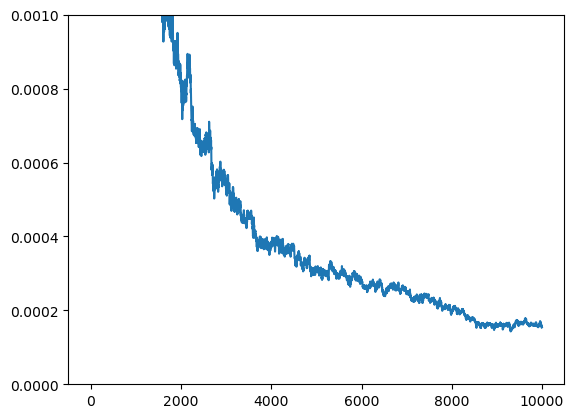

In [9]:
plt.plot(error_at_each_step)
# max y val is 0.01
plt.ylim(0, 0.001)